In [1]:
from datetime import datetime
from dateutil.parser import parse

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
atlas_mun = pd.read_csv("AtlasBrasil_IndicadoresSociais.csv", sep=";")
painel_covid = pd.read_csv("HIST_PAINEL_COVIDBR_18mai2020.csv", sep=";")
data_inloco = pd.read_csv("inloco_mun_1705.csv", sep=";")

# Experimento 1 - Predição da quantidade total de casos no RN com base em valores passados

#### Nesse experimento iremos utilizar apenas os valores passados de casos de corona virus para estimar qual será a quantidade de casos no futuro.

In [3]:
atlas_mun = atlas_mun.drop(atlas_mun.index[0])
atlas_mun

,Código,Espacialidades,Índice de Gini 2010,% de pessoas em domicílios com abastecimento de água e esgotamento sanitário inadequados 2010,IDHM Renda 2010,IDHM Educação 2010,Taxa de envelhecimento 2010,% de extremamente pobres 2010
1,2400109,Acari,"0,49","2,06","0,633","0,634","9,88","5,18"
2,2400208,Açu,"0,53","10,49","0,641","0,568","6,99","7,68"
3,2400307,Afonso Bezerra,"0,53","18,03","0,56","0,502","9,22","21,79"
4,2400406,Água Nova,"0,44","3,11","0,527","0,572","7,65","17,77"
5,2400505,Alexandria,"0,53","10,68","0,581","0,491","11,07","21,46"
...,...,...,...,...,...,...,...,...
163,2414704,Várzea,"0,48","9,25","0,577","0,552","11,12","12,47"
164,2414753,Venha-Ver,"0,5","18,49","0,501","0,473","6,23","33,73"
165,2414803,Vera Cruz,"0,42","8,9","0,558","0,494","7,59","12,44"
166,2414902,Viçosa,"0,47","9,58","0,552","0,502","8,9",19


In [4]:
painel_covid_rn = painel_covid[painel_covid.estado == "RN"]
painel_covid_rn = painel_covid_rn[pd.notna(painel_covid_rn.municipio)]

painel_covid_rn

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,obitosAcumulado,Recuperadosnovos,emAcompanhamentoNovos
21472,Nordeste,RN,Acari,24,240010.0,24004.0,4ª Região de Saúde - Caicó,14/4/2020,16,11136.0,1,0,NaN,NaN
21473,Nordeste,RN,Acari,24,240010.0,24004.0,4ª Região de Saúde - Caicó,15/4/2020,16,11136.0,1,0,NaN,NaN
21474,Nordeste,RN,Acari,24,240010.0,24004.0,4ª Região de Saúde - Caicó,16/4/2020,16,11136.0,1,0,NaN,NaN
21475,Nordeste,RN,Acari,24,240010.0,24004.0,4ª Região de Saúde - Caicó,17/4/2020,16,11136.0,1,0,NaN,NaN
21476,Nordeste,RN,Acari,24,240010.0,24004.0,4ª Região de Saúde - Caicó,18/4/2020,16,11136.0,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24232,Nordeste,RN,Upanema,24,241460.0,24002.0,2ª Região de Saúde - Mossoró,17/5/2020,21,14659.0,2,0,NaN,NaN
24233,Nordeste,RN,Upanema,24,241460.0,24002.0,2ª Região de Saúde - Mossoró,18/5/2020,21,14659.0,2,0,NaN,NaN
24234,Nordeste,RN,Várzea,24,241470.0,24001.0,1ª Região de Saúde - São José de Mipibu,16/5/2020,20,5500.0,1,0,NaN,NaN
24235,Nordeste,RN,Várzea,24,241470.0,24001.0,1ª Região de Saúde - São José de Mipibu,17/5/2020,21,5500.0,1,0,NaN,NaN


In [5]:
dates = np.unique(painel_covid_rn['data'])

cases = []

for date in dates:
  painel_covid_date = painel_covid_rn[painel_covid_rn.data == date]
  n_cases_date = painel_covid_date.aggregate('sum')['casosAcumulado']
  cases.append(n_cases_date)

In [6]:
formated_dates = [datetime.strptime(date, '%d/%m/%Y') for date in dates]

In [7]:
n_casos_rn = pd.DataFrame(data = {'dates': formated_dates, 'sumCases':cases })
n_casos_rn = n_casos_rn.sort_values(by=['dates'], ascending=True)

n_casos_rn

,dates,sumCases
31,2020-03-28,45
33,2020-03-29,67
37,2020-03-30,75
39,2020-03-31,80
0,2020-04-01,90
21,2020-04-02,103
35,2020-04-03,171
40,2020-04-04,209
42,2020-04-05,235
44,2020-04-06,242


## Criação Modelo

In [8]:
length_data = n_casos_rn.shape[0]

size_train = int(0.7 * length_data)
size_val = int(0.2 * length_data)
size_test = int(0.1 * length_data)

indexes_samples_train = np.arange(0, size_train)
indexes_samples_val = np.arange(size_train, size_train + size_val)
indexes_samples_test = np.arange(size_train + size_val, size_train + size_val + size_test)

days = np.arange(length_data)

x_train = days[indexes_samples_train]
x_val = days[indexes_samples_val]
x_test = days[indexes_samples_test]

y_train = n_casos_rn['sumCases'].to_numpy()[indexes_samples_train]
y_val = n_casos_rn['sumCases'].to_numpy()[indexes_samples_val]
y_test = n_casos_rn['sumCases'].to_numpy()[indexes_samples_test]

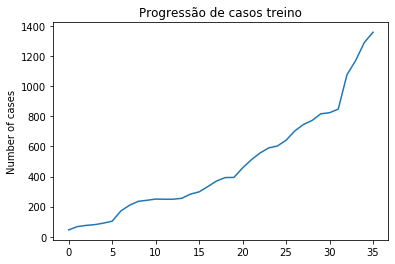

In [9]:
plt.plot(y_train)
plt.ylabel('Number of cases')
plt.title('Progressão de casos treino')
plt.show()

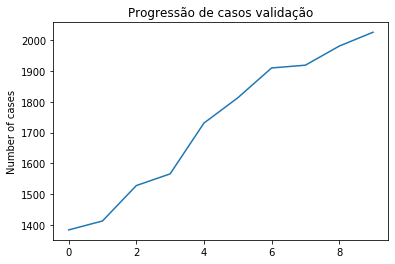

In [10]:
plt.plot(y_val)
plt.ylabel('Number of cases')
plt.title('Progressão de casos validação')
plt.show()

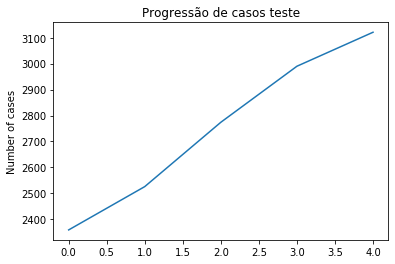

In [11]:
plt.plot(y_test)
plt.ylabel('Number of cases')
plt.title('Progressão de casos teste')
plt.show()

## Geração de Modelo de Regressão Polinomial

In [12]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 4)
x_train_poly = poly.fit_transform(x_train.reshape(-1,1))
x_test_poly = poly.transform(x_test.reshape(-1,1))
x_val_poly = poly.transform(x_val.reshape(-1,1))

In [13]:
regressor = LinearRegression()
regressor.fit(x_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
score = regressor.score(x_train_poly, y_train)
score

0.9901008788023993

In [15]:
previsoes = regressor.predict(x_test_poly)

In [16]:
mae = mean_absolute_error(y_test, previsoes)
mse = mean_squared_error(y_test, previsoes)
print(mae, mse)

1515.775260249107 2351615.5085648913


Text(0, 0.5, 'Numero de casos')

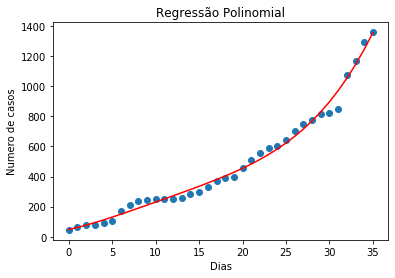

In [17]:
plt.scatter(x_train, y_train)
plt.plot(x_train, regressor.predict(x_train_poly), color = 'red')
plt.title('Regressão Polinomial')
plt.xlabel('Dias')
plt.ylabel('Numero de casos')

In [ ]:
r2_score = r2_score()